<a href="https://colab.research.google.com/github/Navaldeep21/stress-detection-ecg-gsr/blob/main/COEN691_ECG_GSR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install neurokit2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 4.1 MB/s eta 0:00:00


In [ ]:
!pip install google-colab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import neurokit2 as nk
import datetime
from scipy import signal
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [ ]:
def process_EDA_data(data):
    empatica_samp_time = 1/4
    label_samp_time = 1/700

    i = round(empatica_samp_time / label_samp_time)

    labels = data['label'][::i]
    eda = data['signal']['wrist']['EDA'][:len(labels)]
    time = np.arange(0, len(labels)) * empatica_samp_time * 1e03

    df = pd.DataFrame({"Labels":labels, "EDA":eda.flatten(), "Time":time}).reset_index(drop=True)
    stress = df[df['Labels'] == 2].reset_index(drop=True)
    meditation = df[df['Labels'] == 4].reset_index(drop=True)
    baseline = df[df['Labels'] == 1].reset_index(drop=True)

    return df, stress, baseline, meditation

In [ ]:
def Analyze_EDA_data(eda_data, timewidth):
    # Median Filtering
    eda_data["EDA"] = signal.medfilt(eda_data["EDA"].values, kernel_size=7)

    # Resampling Data
    y = eda_data['EDA'].values
    yn = (y - y.mean()) / y.std()
    eda_resampled = signal.resample(yn, len(eda_data)*3)
    sampFreq = len(eda_resampled) / ((eda_data['Time'].iloc[-1] - eda_data['Time'].iloc[0]) * 1e-03)

    t_resampled = np.arange(eda_data['Time'].iloc[0], eda_data['Time'].iloc[-1], 1/sampFreq * 1e03)
    t_dt_resampled = pd.to_datetime(t_resampled * 1e06)

    signals, info = nk.eda_process(eda_resampled, sampling_rate=sampFreq)

    if len(signals) <= len(t_dt_resampled):
        signals['timestamp'] = t_dt_resampled[:len(signals)]
        signals['time'] = t_resampled[:len(signals)]

    elif len(signals) > len(t_dt_resampled):
        d = len(signals) - len(t_dt_resampled)
        signals = signals.iloc[:-d]
        signals['timestamp'] = t_dt_resampled[:len(signals)]
        signals['time'] = t_resampled[:len(signals)]

    signals.set_index('timestamp', inplace=True)
    minute_bins = signals.resample(str(timewidth) + 'T')

    mean_scr = []
    sd_scr = []
    n_scr = []
    mean_scl = []
    sd_scl = []
    slope_scl = []

    for _, minute_data in minute_bins:


        time_slice = minute_data

        scr = time_slice[time_slice['SCR_Peaks'] == 1]
        mean_scr.append(np.mean(scr['SCR_Amplitude']))
        sd_scr.append(np.std(scr['SCR_Amplitude']))
        n_scr.append(len(scr['SCR_Amplitude']))

        mean_scl.append(np.mean(time_slice["EDA_Tonic"]))
        sd_scl.append(np.std(time_slice["EDA_Tonic"]))


    results = pd.DataFrame({'Mean_SCR':mean_scr, 'STD_SCR':sd_scr,'N_SCR':n_scr, 'Mean_SCL':mean_scl, 'STD_SCL':sd_scl})
    results = results.fillna(0)
    return results

In [ ]:
def process_BVP_data(data):
    empatica_samp_time = 1/64
    label_samp_time = 1/700

    i = round(empatica_samp_time / label_samp_time)

    labels = data['label'][::i]
    bvp = data['signal']['wrist']['BVP'][:len(labels)]
    time = np.arange(0, len(labels)) * empatica_samp_time * 1e03

    df = pd.DataFrame({"Labels":labels, "BVP":bvp.flatten(), "Time":time}).reset_index(drop=True)
    stress = df[df['Labels'] == 2].reset_index(drop=True)
    meditation = df[df['Labels'] == 4].reset_index(drop=True)
    baseline = df[df['Labels'] == 1].reset_index(drop=True)

    return df, stress, baseline, meditation

In [ ]:
def Analyze_HRV_data(bvp, timewidth=5):
    bvp['timestamp'] = pd.to_datetime(bvp['Time'] * 1e06)
    bvp.set_index('timestamp', inplace=True)
    minute_bins = bvp.resample(str(timewidth) + 'T')

    time_stats = pd.DataFrame([])
    freq_stats = pd.DataFrame([])
    label_array = []

    for minute, minute_data in minute_bins:

        try:
            _, peaks = nk.ppg_process(minute_data['BVP'], sampling_rate=64)
        except:
            peaks = []

        # Time Parameters
        try:
            time_stats = pd.concat([time_stats, nk.hrv_time(peaks, sampling_rate=64)], axis=0, ignore_index=True)
        except:
            time_stats = pd.concat([time_stats, pd.DataFrame(np.zeros((1, len(time_stats.columns))), columns=time_stats.columns)], axis=0, ignore_index=True)

        # Frequency Parameters
        try:
            freq_stats = pd.concat([freq_stats, nk.hrv_frequency(peaks, sampling_rate=64)], axis=0, ignore_index=True)
        except:
            freq_stats = pd.concat([freq_stats, pd.DataFrame(np.zeros((1, len(freq_stats.columns))), columns=freq_stats.columns)], axis=0, ignore_index=True)

        try:
            label_array.append(minute_data['Labels'].values[0])
        except:
            label_array.append(np.nan)


    label_array = pd.DataFrame({"labels":label_array})
    results = pd.concat([time_stats, freq_stats, label_array], axis=1)
    return results

In [ ]:
from google.colab import drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dir_path = "/content/drive/MyDrive/WESAD"
participants = os.listdir(dir_path)
timewidth = 5

participants_data = {}

for p in tqdm(participants):

    df = pd.DataFrame()

    base_directory = "/content/drive/MyDrive/WESAD"

    # Get a list of folders in the base directory
    folders = os.listdir(base_directory)

    # Iterate over each folder
    for folder in folders:
        # Construct the full path to the folder
        folder_path = os.path.join(base_directory, folder)

        # Check if the item in the directory is a folder
        if os.path.isdir(folder_path):
            # Get the list of files in the folder
            files = os.listdir(folder_path)

            # Iterate over each file in the folder
            for file in files:
                # Check if the file is a pickle file
                if file.endswith('.pkl'):
                    # Construct the full path to the pickle file
                    pickle_file_path = os.path.join(folder_path, file)

                    # Load the pickle file
                    with open(pickle_file_path, 'rb') as f:
                        data = pickle.load(f, encoding='latin1')

                    fd_h, stress_h, baseline_h, meditation_h = process_BVP_data(data)
                    fd_e, stress_e, baseline_e, meditation_e = process_EDA_data(data)

                    # Forming Baseline Data
                    base_hrv = Analyze_HRV_data(baseline_h, timewidth=timewidth)
                    base_eda = Analyze_EDA_data(baseline_e, timewidth=timewidth)
                    base_stats = pd.concat([base_hrv, base_eda], axis=1).reset_index(drop=True)
                    base_stats = pd.concat([base_stats, pd.DataFrame({'Stress':np.zeros(len(base_stats))})], axis=1).reset_index(drop=True)

                    # Forming Stress Data
                    stress_hrv = Analyze_HRV_data(stress_h, timewidth=timewidth)
                    stress_eda = Analyze_EDA_data(stress_e, timewidth=timewidth)
                    stress_stats = pd.concat([stress_hrv, stress_eda], axis=1).reset_index(drop=True)
                    stress_stats = pd.concat([stress_stats, pd.DataFrame({'Stress':np.ones(len(stress_stats))})], axis=1).reset_index(drop=True)

                    ih = np.where(np.diff(meditation_h['Time'].values) > np.mean(np.diff(meditation_h['Time'].values)))[0][0]
                    ie = np.where(np.diff(meditation_e['Time'].values) > np.mean(np.diff(meditation_e['Time'].values)))[0][0]

                    med_h = meditation_h.iloc[0: ih + 1].reset_index(drop=True)
                    med_e = meditation_e.iloc[0: ie + 1].reset_index(drop=True)
                    med_hrv  = Analyze_HRV_data(med_h, timewidth=timewidth)
                    med_eda = Analyze_EDA_data(med_e, timewidth=timewidth)
                    med_stats_1 = pd.concat([med_hrv, med_eda], axis=1).reset_index(drop=True)
                    med_stats_1 = pd.concat([med_stats_1, pd.DataFrame({'Stress':np.ones(len(med_stats_1))*-1})], axis=1).reset_index(drop=True)

                    med_h = meditation_h.iloc[ih + 1:].reset_index(drop=True)
                    med_e = meditation_e.iloc[ie + 1:].reset_index(drop=True)
                    med_hrv  = Analyze_HRV_data(med_h, timewidth=timewidth)
                    med_eda = Analyze_EDA_data(med_e, timewidth=timewidth)
                    med_stats_2 = pd.concat([med_hrv, med_eda], axis=1).reset_index(drop=True)
                    med_stats_2 = pd.concat([med_stats_2, pd.DataFrame({'Stress':np.ones(len(med_stats_1))*-1})], axis=1).reset_index(drop=True)

                    df = pd.concat([df, base_stats, stress_stats, med_stats_1, med_stats_2]).reset_index(drop=True)
                    df = df.drop(columns=['HRV_SDANN2', 'HRV_SDNNI2', 'HRV_SDANN5', 'HRV_SDNNI5', 'HRV_ULF'])

                    full_hrv = Analyze_HRV_data(fd_h, timewidth=timewidth)
                    full_eda = Analyze_EDA_data(fd_e, timewidth=timewidth)
                    full_stats = pd.concat([full_hrv, full_eda], axis=1).reset_index(drop=True)

                    participants_data[p] = {}
                    participants_data[p]["processed_data"] = df
                    participants_data[p]["full_data"] = full_stats


100%|██████████| 16/16 [55:33<00:00, 208.36s/it]


In [ ]:
drop_cols = []
corr_cols = ["HRV_SDSD", "HRV_SDNN", "HRV_CVNN", "HRV_CVSD", "HRV_Prc20NN", "HRV_MadNN", "HRV_VHF", "HRV_TP", "HRV_Prc80NN", "HRV_MCVNN", "HRV_pNN50", "HRV_HF", "HRV_LF", "HRV_SDRMSSD", "HRV_VLF"]

filtered_df = {}

for participant in participants_data.keys():
    d = participants_data[participant]['processed_data'].fillna(0)
    for cols in d.columns:
        if (d[cols] == 0).all():
            drop_cols.append(cols)
        if cols == "Stress":
            drop_cols.append(cols)
        if cols in corr_cols:
            drop_cols.append(cols)
    d = d.drop(columns=drop_cols)
    d = d[((d == 0).sum(axis=1) / d.shape[1]) < 0.5]
    filtered_df[participant] = d

In [ ]:
def clean_data(d):
    drop_cols = []
    corr_cols = ["HRV_SDSD", "HRV_SDNN", "HRV_CVNN", "HRV_CVSD", "HRV_Prc20NN", "HRV_MadNN", "HRV_VHF", "HRV_TP", "HRV_Prc80NN", "HRV_MCVNN", "HRV_pNN50", "HRV_HF", "HRV_LF", "HRV_SDRMSSD", "HRV_VLF"]
    d = d.fillna(0)
    for cols in d.columns:
        if (d[cols] == 0).all():
            drop_cols.append(cols)
        if cols == "Stress":
            drop_cols.append(cols)
        if cols in corr_cols:
            drop_cols.append(cols)
    d = d.drop(columns=drop_cols)
    d = d[((d == 0).sum(axis=1) / d.shape[1]) < 0.5]
    return d

In [ ]:
cleaned_data = clean_data(d)

# Print the first few rows of the cleaned DataFrame
print(cleaned_data.head())

   HRV_MeanNN  HRV_SDANN1  HRV_SDNNI1   HRV_RMSSD  HRV_MedianNN  HRV_IQRNN  \
0  913.423295   35.836524  233.624240  334.474604       906.250  296.87500   
1  940.457413   44.248774  285.018637  388.821986       921.875  296.87500   
2  918.173077   57.267776  225.911447  296.560099       906.250  281.25000   
3  947.750796   59.199283  287.633989  400.893392       953.125  261.71875   
4  857.088415    0.000000    0.000000  282.175475       859.375  292.96875   

   HRV_pNN20  HRV_MinNN  HRV_MaxNN    HRV_HTI  ...  HRV_LFHF   HRV_LFn  \
0  91.818182    359.375   1718.750  24.444444  ...  0.401427  0.197844   
1  88.958991    312.500   3796.875  22.642857  ...  1.840709  0.509291   
2  89.846154    312.500   1812.500  20.312500  ...  0.691675  0.247897   
3  92.993631    312.500   3015.625  18.470588  ...  0.492009  0.272894   
4  87.804878    312.500   1312.500  16.400000  ...  0.672921  0.345069   

    HRV_HFn  HRV_LnHF  labels  Mean_SCR   STD_SCR  N_SCR  Mean_SCL   STD_SCL  
0  0.49

<Axes: >

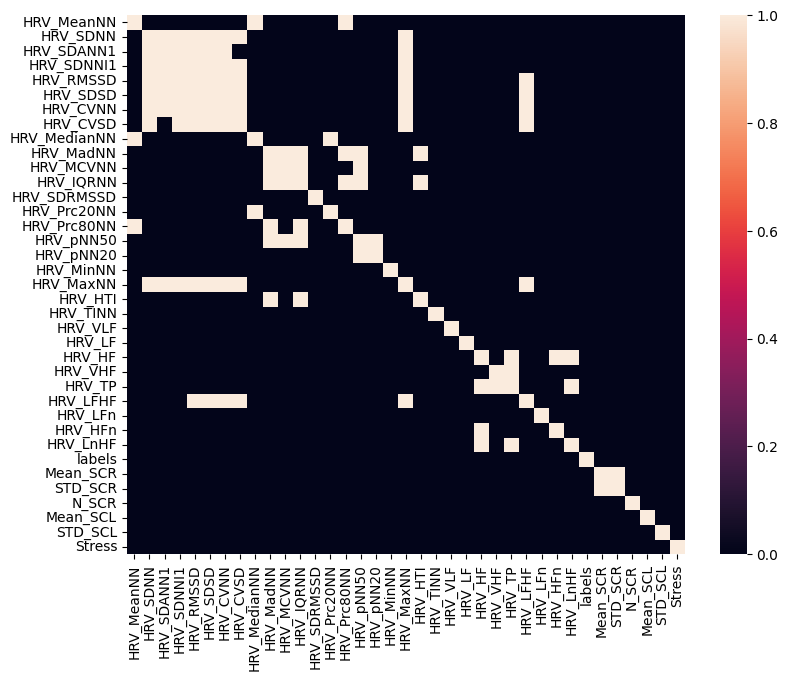

In [ ]:
plt.figure(figsize=(9,7))
sns.heatmap(participants_data['participant_10']['processed_data'].corr() > 0.7)

<Axes: >

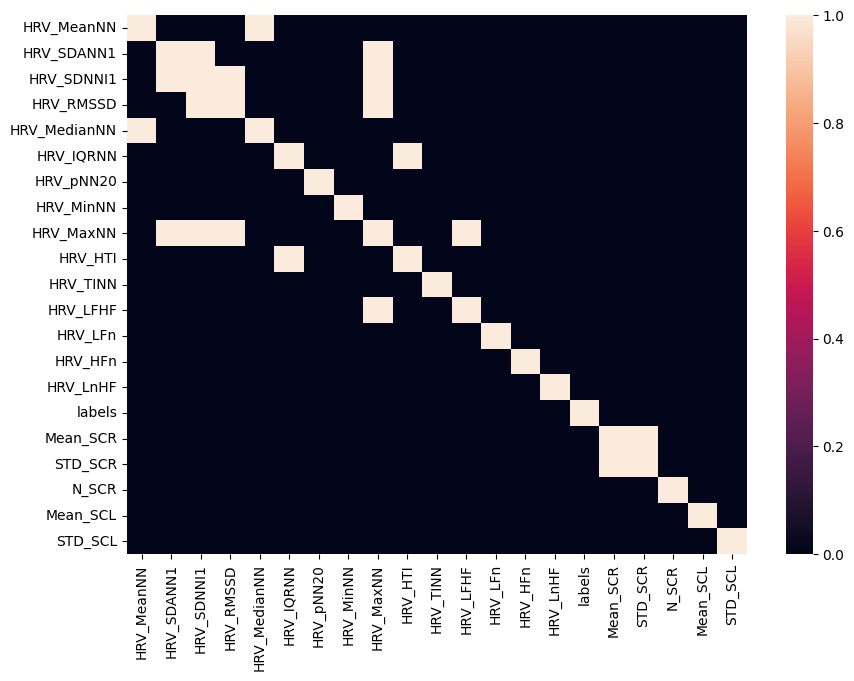

In [ ]:
plt.figure(figsize=(10,7))
sns.heatmap(filtered_df['participant_10'].corr() > 0.7)

In [ ]:
!pip install scikit-learn

In [ ]:
from sklearn.model_selection import train_test_split

X = cleaned_data.drop(columns=['labels'])
y = cleaned_data['labels']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, f1_score

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Make predictions on the testing set
y_pred_rf = rf_classifier.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", accuracy_rf)
classification_rep = classification_report(y_test, y_pred_rf)

f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
print("F1 Score:", f1_rf)

# Print classification report
print("Classification Report:")
print(classification_rep)

Random Forest Accuracy: 0.7894736842105263
F1 Score: 0.7971291866028708
Classification Report:
              precision    recall  f1-score   support

         1.0       0.50      0.88      0.64         8
         2.0       1.00      1.00      1.00        12
         4.0       0.92      0.61      0.73        18

    accuracy                           0.79        38
   macro avg       0.81      0.83      0.79        38
weighted avg       0.86      0.79      0.80        38



In [ ]:
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression classifier
lr_classifier = LogisticRegression(max_iter=1000, random_state=42)

# Train the classifier
lr_classifier.fit(X_train, y_train)

# Make predictions on the testing set
y_pred_lr = lr_classifier.predict(X_test)

# Evaluate the model
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print("Logistic Regression Accuracy:", accuracy_lr)

# Generate classification report
report = classification_report(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr, average='weighted')
print("F1 Score:", f1)

# Print the classification report
print("Classification Report:")
print(report)

Logistic Regression Accuracy: 0.7368421052631579
F1 Score: 0.7431077694235589
Classification Report:
              precision    recall  f1-score   support

         1.0       0.44      0.88      0.58         8
         2.0       1.00      1.00      1.00        12
         4.0       0.90      0.50      0.64        18

    accuracy                           0.74        38
   macro avg       0.78      0.79      0.74        38
weighted avg       0.83      0.74      0.74        38



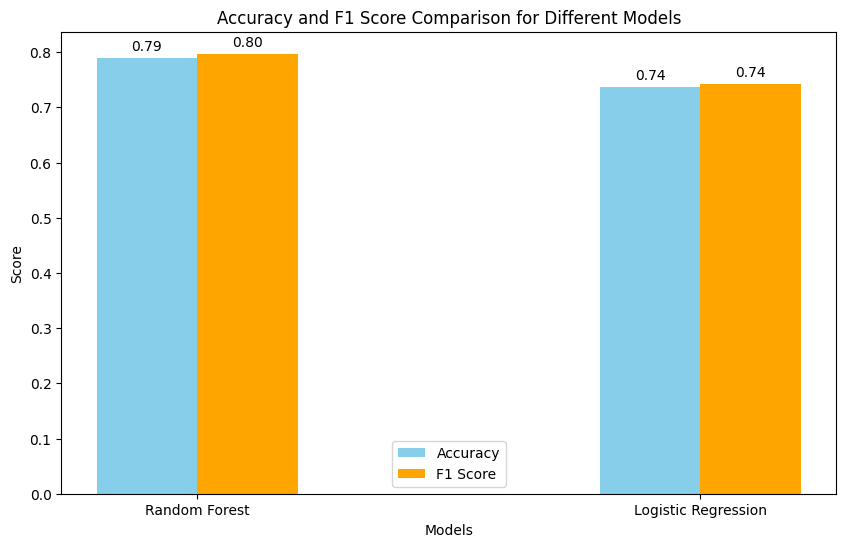

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define models
models = ['Random Forest', 'Logistic Regression']

# Define positions for the bars
x = np.arange(len(models))

# Width of the bars
width = 0.20

# Plotting accuracy and F1 score for both models
plt.figure(figsize=(10, 6))
bar1 = plt.bar(x - width/2, [accuracy_rf, accuracy_lr], width, label='Accuracy', color='skyblue')
bar2 = plt.bar(x + width/2, [f1_rf, f1_lr], width, label='F1 Score', color='orange')


# Add text labels, titles, and legend
plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Accuracy and F1 Score Comparison for Different Models')
plt.xticks(x, models)
plt.legend()

# Add data labels on top of each bar
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.annotate('{:.2f}'.format(height),
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),
                     textcoords='offset points',
                     ha='center', va='bottom')

add_labels(bar1)
add_labels(bar2)

# Display the plot
plt.show()
